In [254]:
import pandas as pd
import numpy as np

#Modelisation
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso

#Fonction test model
from Test_Model import test_model
%matplotlib inline

# III/ Comparaison de l'erreur de prédiction de différentes méthodes statistiques

Jusqu'à maintenant, nous avons démontré que les stratégies d'investissements obtenues à partir de la résolution du problème de Markovitz (équivalent à la résolution d'un problème des moindres carrés => démonstration dans le fichier LaTeX) ne sont pas très convaincantes. Nous allons donc tester plusieurs autres méthodes statistiques de prédiction des rendements futurs et allons mettre en place une métrique commune qui mesure l'erreur de prédiction obtenue. 



Ici on crée l'interface qui nous permet de choisir le nombre d'actifs considéré, le nombre de dates, la vraie loi des rendements

In [255]:
nb_actifs = 20
nb_dates = 256 * 5

idx = pd.Index(np.arange(nb_actifs))
idx_date = pd.Index(np.arange(nb_dates))

esp_rdt = 0.05
vol_rdt = 0.2
correl = 0.7
seuil_pb_marko = 0.05
mu = pd.Series(esp_rdt,index=idx)
vols = pd.Series(vol_rdt,index=idx)
#Le vecteur constant cible que l'on essayer d'estimer -> chaque composante du vecteur est le rendement du protefeuille optimal tous  les jours
allocation_optimale_théorique = pd.Series(esp_rdt, index = idx_date)

#Matrice var-covar théorique selon la vraie loi des rendements
covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((nb_actifs,nb_actifs)) + (1-correl) * np.eye(nb_actifs),index=idx,columns=idx) @ np.diag(vols)

In [256]:
#On simuler un tirage de rendements suivant une loi normale d'espérence Mu et de Var la matrice Covar
A = np.linalg.cholesky(covar)
rdts_observes = mu/256 + pd.DataFrame(np.random.randn(nb_dates,nb_actifs)) @ A.T / 16

Ici on calcule les estimateurs d'espérance et de variance empiriques de la série des observations

In [257]:
mu_estime = rdts_observes.mean() * 256
covar_estimee = rdts_observes.cov() * 256

#Suivant la formule de la résolution du problème, on calcule l'allocation optimale "in sample"

covar_inv = np.linalg.inv(covar_estimee)
df_covar_inv = pd.DataFrame(covar_inv,index=idx,columns=idx)
lambda1 = seuil_pb_marko/(mu_estime @ df_covar_inv @ mu_estime)
alloc_optimale_in_sample = lambda1 * (df_covar_inv @ mu_estime)

A priori, nous pouvons nous ramener à la résolution d'un problème des moindres carrés. Donc nous allons effectuer la régression de la vraie allocation optimale sur les rendements observés. Le Beta que l'on obtient devrait être le plus proche possible de l'allocation optimale théorique. 

In [258]:
print(allocation_optimale_théorique)

0       0.05
1       0.05
2       0.05
3       0.05
4       0.05
        ... 
1275    0.05
1276    0.05
1277    0.05
1278    0.05
1279    0.05
Length: 1280, dtype: float64


In [259]:
regression = LinearRegression()

# Entraîner le modèle sur les données
regression.fit(rdts_observes, allocation_optimale_théorique)

# Obtenir les coefficients de la régression
coefficients = regression.coef_
intercept = regression.intercept_

On réalise la régression sans intercept car la variable sur laquelle on régresse est colinéaire avec le vecteur constant égale à 1

In [260]:
regression_sans_intercept = LinearRegression(fit_intercept = False)

# Entraîner le modèle sur les données
regression_sans_intercept.fit(rdts_observes, allocation_optimale_théorique)

# Obtenir les coefficients de la régression
coefficients_bis = regression_sans_intercept.coef_
intercept_bis = regression_sans_intercept.intercept_

On normalise le vecteur d'allocation entre les actifs in sample afin que la somme de ses poids soit égale à 1 et pareil pour le vecteur des coefficients qui sort de la régression sans intercept. 

On voit que l'on retrouve bien l'allocation in sample de la partie I. 

In [261]:
#Coefficients problème de Markovitz
alloc_optimale_in_sample_normalized = alloc_optimale_in_sample * (1 / sum(alloc_optimale_in_sample))
#Coefficients issues de la régression
coefficients_bis_normalized = coefficients_bis * (1 / sum(coefficients_bis))

print(alloc_optimale_in_sample_normalized - coefficients_bis_normalized)

0    -7.659651e-12
1    -1.470823e-12
2     4.412470e-12
3    -1.430855e-12
4    -1.465494e-12
5     1.756817e-12
6     3.973710e-12
7    -3.145928e-12
8     2.790657e-12
9     8.646417e-13
10   -1.092459e-12
11    3.996803e-12
12    5.426770e-13
13   -2.790657e-12
14   -3.288037e-12
15    1.239009e-12
16    3.859135e-13
17    1.519673e-12
18    1.760370e-12
19   -9.023893e-13
dtype: float64


## A/ Régressions pénalisées

Dans cette partie, nous allons tester des régressions pénalisées afin de pouvoir comparer l'erreur de prédiction avec les précédentes méthodes

### 1/ Création des échantillons train/test

Ici, nous allons régresser le vecteur "allocation_optimale_theorique" qui est un vecteur colinéaire au vecteur constant égal à 1 et qui contient la performance, jour par jour, du portfolio optimal dans notre exemple

In [262]:
nb_dates_test = 256
nb_simu = 1000

In [263]:
X_train = rdts_observes
Y_train = allocation_optimale_théorique

X_test = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
Y_test = allocation_optimale_théorique[:256] #Car les lois des actifs n'ont pas été modifiées

In [264]:
def test_model_NB(X_train, X_test, y_train, y_test, DF, model) : 

    #on run le modèle avec les fonctions prebuilt
    ols =  model.fit(X_train, y_train)
    y_pred = ols.predict(X_test)

    #On affiche le R^2 du modèle calculé à partir des échantillons Train -> pourquoi est ce que c'est n'importe quoi ? 
    print("R_2 du modèle : " +str(ols.score(X_train, y_train)))
    print(f"Le MSE (Mean Squared Error) de notre prédiction est de {mean_squared_error(y_pred, y_test)}")
    print(f"Le MAE (Mean Absolute Error) de notre prédiction est de {mean_absolute_error(y_pred, y_test)}")


    coefs = pd.DataFrame(ols.coef_, columns=['Coefficients'], index = DF.columns)
    coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
    coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
    plt.title('Régression linéaire')
    plt.axvline(x=0, color='1')
    plt.grid()
    plt.subplots_adjust(left=.3)

    return f"l'allocation optimale selon ce modèle est {ols.coef_}"

R_2 du modèle : -5.1541046150882445e+31
Le MSE (Mean Squared Error) de notre prédiction est de 0.002538803662193474
Le MAE (Mean Absolute Error) de notre prédiction est de 0.05019635430114795


"l'allocation optimale selon ce modèle est [ 0.3706301   0.07235246 -0.21410309  0.06927263  0.0702306  -0.08580007\n -0.19006636  0.14882136 -0.13712478 -0.04135841  0.05204233 -0.19462841\n -0.02874181  0.13361905  0.15670153 -0.06229915 -0.01960673 -0.0706645\n -0.08244731  0.03962544]"

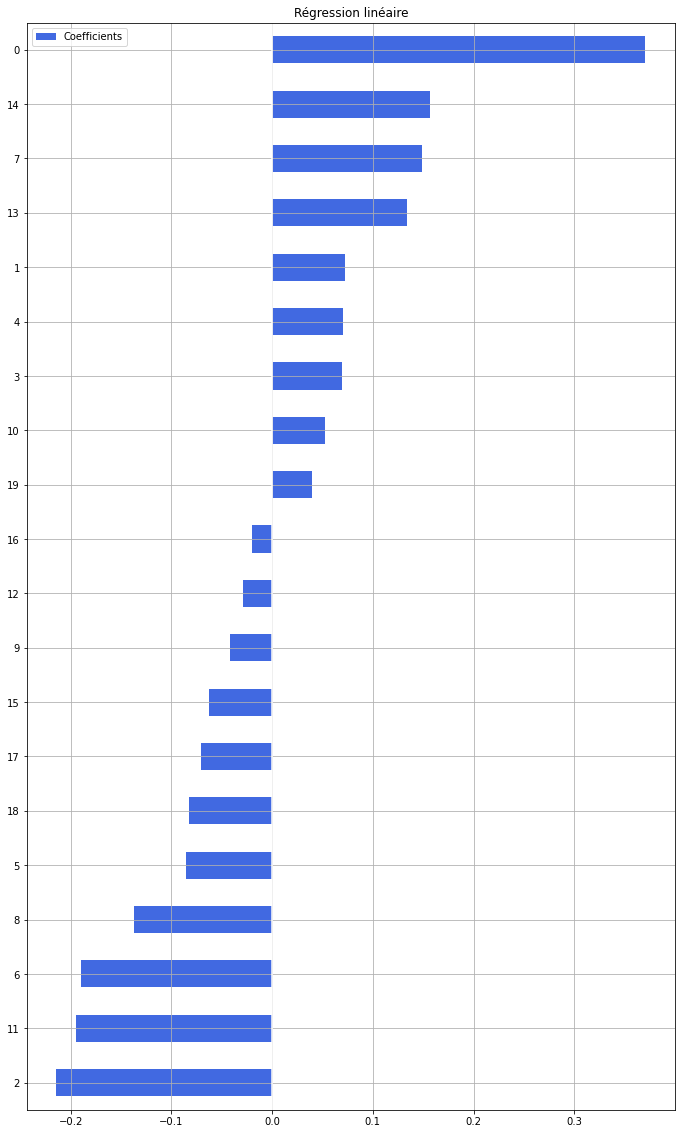

In [265]:
test_model_NB(X_train, X_test, Y_train, Y_test, X_train, LinearRegression(fit_intercept = False))

Le MSE (Mean Squared Error) de notre prédiction est de 0.002538803662193474
Le MAE (Mean Absolute Error) de notre prédiction est de 0.05019635430114795
[-27.36263493  -5.34158996  15.80666153  -5.11421438  -5.18493812
   6.33439121  14.03209402 -10.98708531  10.12355826   3.05338128
  -3.84214709  14.36889779   2.12193112  -9.8647389  -11.56885755
   4.59938055   1.44751306   5.2169724    6.086866    -2.925441  ]


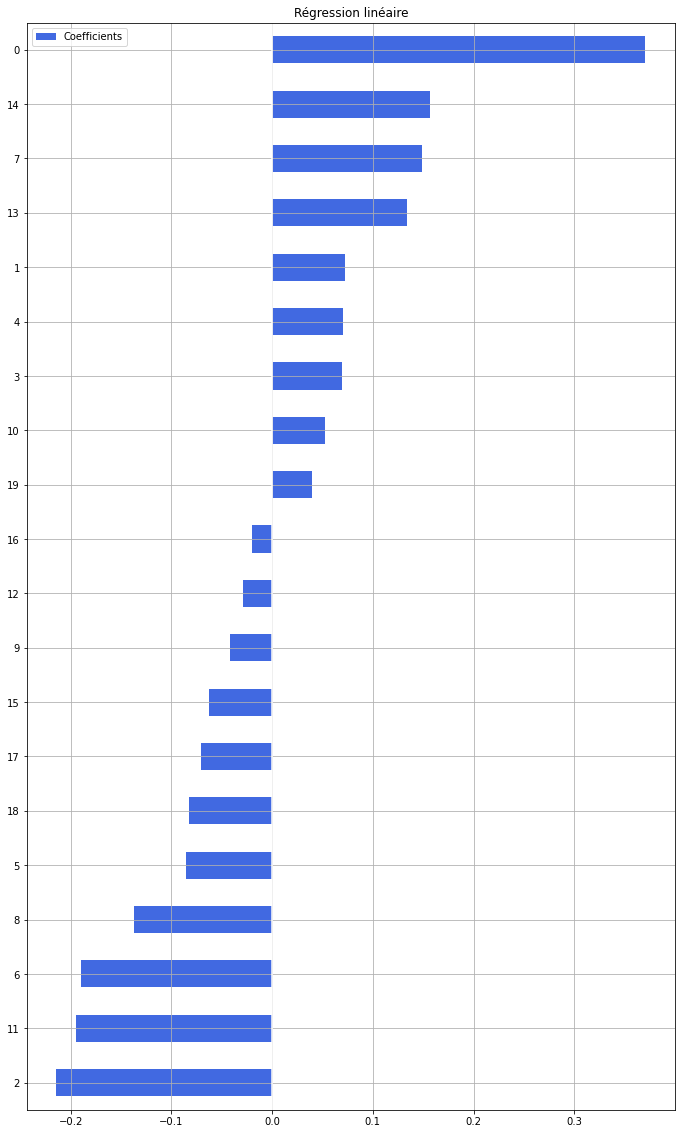

In [297]:
reg = LinearRegression(fit_intercept = False)
model =  reg.fit(X_train, Y_train)
coef_reglin = model.coef_
y_pred = model.predict(X_test)

print(f"Le MSE (Mean Squared Error) de notre prédiction est de {mean_squared_error(y_pred, Y_test)}")
print(f"Le MAE (Mean Absolute Error) de notre prédiction est de {mean_absolute_error(y_pred, Y_test)}")

coefs = pd.DataFrame(coef_reglin, columns=['Coefficients'], index = X_train.columns)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Régression linéaire')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

#On rend les coefficients normalisés pour que le poid soit égal à 1
coef_reg_lin_normalized = coef_reglin * (1/sum(coef_reglin))
print(coef_reg_lin_normalized)

On affiche les PNL in sample

Sharpe = 1.3767695127002282


<AxesSubplot:>

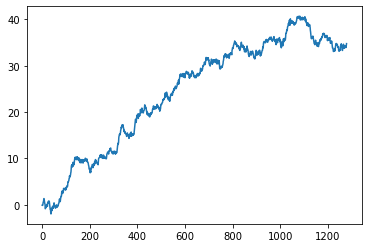

In [283]:
pnl_in_sample_reglin = rdts_observes @ coef_reg_lin_normalized
print('Sharpe = ' + str(pnl_in_sample_reglin.mean()/pnl_in_sample_reglin.std()*16))
pnl_in_sample_reglin.cumsum().plot()

Maintenant, testons les 2 portefeuilles out-sample

Sharpe = 0.7168968792325265


<AxesSubplot:>

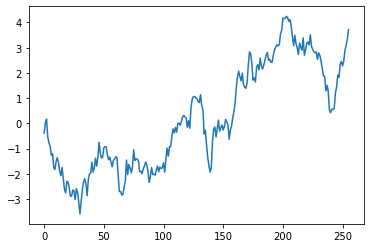

In [286]:
pnl_test_reglin = X_test @ coef_reg_lin_normalized
print('Sharpe = ' + str(pnl_test_reglin.mean()/pnl_test_reglin.std()*16))
pnl_test_reglin.cumsum().plot()

Maintenant, nous allons simuler plusieurs échantillons test et voir, en moyenne, comment se comporte notre portefeuille

In [287]:
pnl_out_sample_reglin = []
sharpe_out_sample_reglin = []

for i in range(nb_simu) : 
    simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
    pnl_simu = simu @ coef_reg_lin_normalized
    pnl_out_sample_reglin.append(pnl_simu)

    sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
    sharpe_out_sample_reglin.append(sharpe_simu)

sharpe_out_sample_DF_reglin = pd.DataFrame(sharpe_out_sample_reglin)
sharpe_out_sample_DF_reglin.describe()
    

,0
count,1000.000000
mean,-0.024673
std,0.970695
min,-3.078815
25%,-0.660483
50%,-0.015064
75%,0.628223
max,2.976880


On affiche les quantiles des sharpe ratio de toutes nos simulations et on trace la moyenne afin de voir le sharpe moyen que nous apporte notre portfolio

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2348212371.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF_reglin.mean())


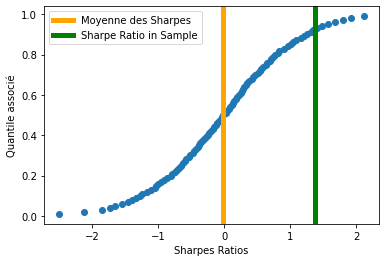

In [288]:
quantiles = sharpe_out_sample_DF_reglin.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
plt.scatter(quantiles['quantile'],quantiles['proba'])

moyenne_sharpe = float(sharpe_out_sample_DF_reglin.mean())
sharpe_in_sample = pnl_in_sample_reglin.mean()/pnl_in_sample_reglin.std()*16
plt.axvline(x=moyenne_sharpe, color='orange', linestyle='-', linewidth=5,  label='Moyenne des Sharpes')
plt.axvline(x=sharpe_in_sample, color='green', linestyle='-', linewidth=5,  label='Sharpe Ratio in Sample')

plt.xlabel('Sharpes Ratios')
plt.ylabel('Quantile associé')
plt.legend()
#plt.scatter(quantiles['quantile']*0 + sharpe_out_sample_DF.mean(),quantiles['proba'])
#plt.scatter(quantiles['quantile']*0 + pnl_in_sample.mean()/pnl_in_sample.std()*16,quantiles['proba'])

Désormais, nous allons faire la même chose avec les régressions pénalisées

Le MSE (Mean Squared Error) de notre prédiction est de 0.002538803662193474
Le MAE (Mean Absolute Error) de notre prédiction est de 0.05019635430114795
[-0.36900983 -0.01075786  0.28152203 -0.04062376  0.01236316  0.14054048
  0.25919179 -0.09595264  0.17956059  0.08432714 -0.02213101  0.28431143
  0.07558562 -0.09626013 -0.13634832  0.12252889  0.07602768  0.1404803
  0.13499591 -0.02035147]


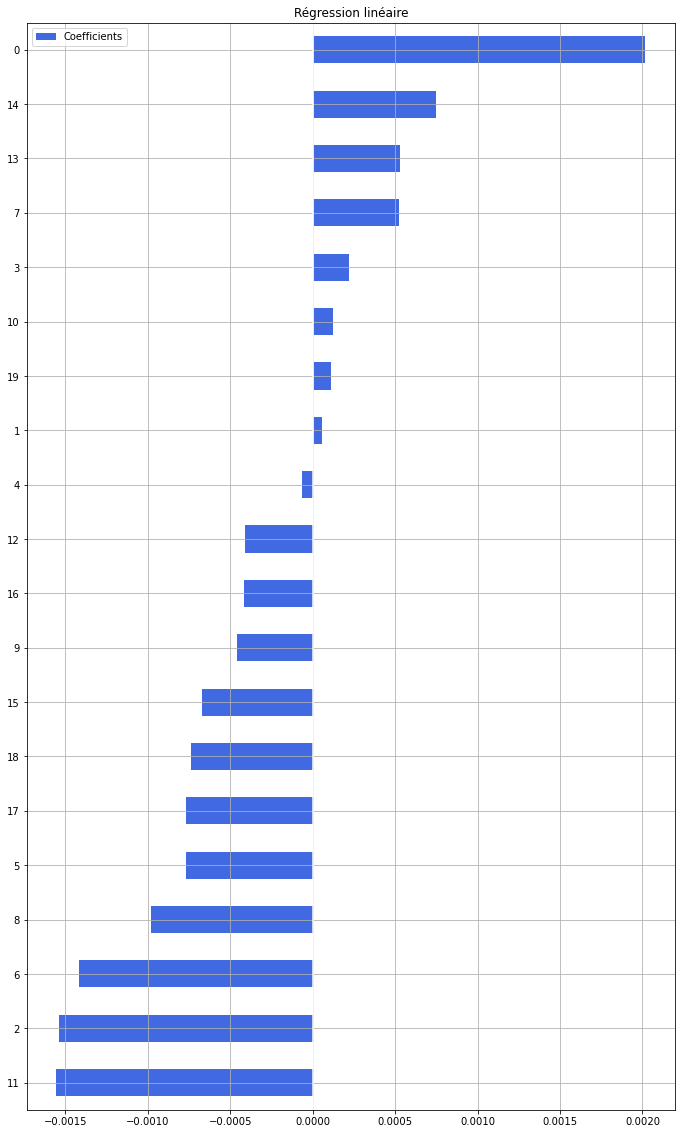

In [298]:
ridge = RidgeCV(fit_intercept = False, cv = 5)
model_ridge =  ridge.fit(X_train, Y_train)
coef_ridge = model_ridge.coef_
y_pred_ridge = model.predict(X_test)

print(f"Le MSE (Mean Squared Error) de notre prédiction est de {mean_squared_error(y_pred_ridge, Y_test)}")
print(f"Le MAE (Mean Absolute Error) de notre prédiction est de {mean_absolute_error(y_pred_ridge, Y_test)}")

coefs = pd.DataFrame(coef_ridge, columns=['Coefficients'], index = X_train.columns)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Régression linéaire')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

#On rend les coefficients normalisés pour que le poid soit égal à 1
coef_ridge_normalized = coef_ridge * (1/sum(coef_ridge))
print(coef_ridge_normalized)

Sharpe = 0.6238293436920022


<AxesSubplot:>

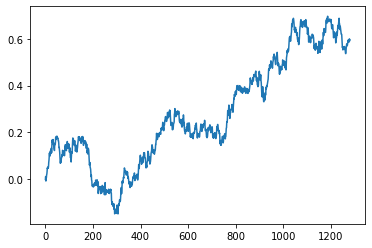

In [290]:
pnl_in_sample_ridge = rdts_observes @ coef_ridge_normalized
print('Sharpe = ' + str(pnl_in_sample_ridge.mean()/pnl_in_sample_ridge.std()*16))
pnl_in_sample_ridge.cumsum().plot()

Sharpe = 0.6916668309343019


<AxesSubplot:>

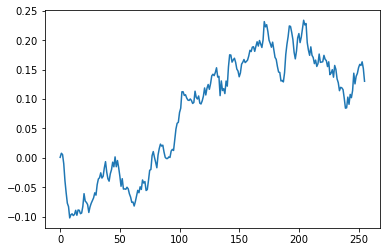

In [293]:
pnl_test_ridge = X_test @ coef_ridge_normalized
print('Sharpe = ' + str(pnl_test_ridge.mean()/pnl_test_ridge.std()*16))
pnl_test_ridge.cumsum().plot()

In [294]:
pnl_out_sample_ridge = []
sharpe_out_sample_ridge = []

for i in range(nb_simu) : 
    simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
    pnl_simu = simu @ coef_ridge_normalized
    pnl_out_sample_ridge.append(pnl_simu)

    sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
    sharpe_out_sample_ridge.append(sharpe_simu)

sharpe_out_sample_DF_ridge = pd.DataFrame(sharpe_out_sample_ridge)
sharpe_out_sample_DF_ridge.describe()

,0
count,1000.000000
mean,0.261637
std,1.012970
min,-2.847343
25%,-0.431439
50%,0.265095
75%,0.915304
max,3.425697


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/756717335.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF_ridge.mean())


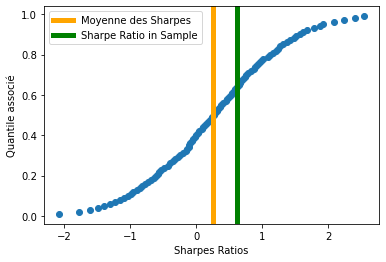

In [295]:
quantiles = sharpe_out_sample_DF_ridge.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
plt.scatter(quantiles['quantile'],quantiles['proba'])

moyenne_sharpe = float(sharpe_out_sample_DF_ridge.mean())
sharpe_in_sample = pnl_in_sample_ridge.mean()/pnl_in_sample_ridge.std()*16
plt.axvline(x=moyenne_sharpe, color='orange', linestyle='-', linewidth=5,  label='Moyenne des Sharpes')
plt.axvline(x=sharpe_in_sample, color='green', linestyle='-', linewidth=5,  label='Sharpe Ratio in Sample')

plt.xlabel('Sharpes Ratios')
plt.ylabel('Quantile associé')
plt.legend()

Comparaison des coefficients obtenus avec la régression classique et la régression Ridge (normalisés)

In [296]:
print(coef_reg_lin_normalized)
print(coef_ridge_normalized)

[-27.36263493  -5.34158996  15.80666153  -5.11421438  -5.18493812
   6.33439121  14.03209402 -10.98708531  10.12355826   3.05338128
  -3.84214709  14.36889779   2.12193112  -9.8647389  -11.56885755
   4.59938055   1.44751306   5.2169724    6.086866    -2.925441  ]
[-0.36900983 -0.01075786  0.28152203 -0.04062376  0.01236316  0.14054048
  0.25919179 -0.09595264  0.17956059  0.08432714 -0.02213101  0.28431143
  0.07558562 -0.09626013 -0.13634832  0.12252889  0.07602768  0.1404803
  0.13499591 -0.02035147]


Pareil avec le LASSO. On utilise Lasso() et non LassoCV() car la pénalisation choisie est trop forte et mène à ne choisir d'investir dans aucun actif

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2128164709.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  coef_lasso_normalized = coef_lasso * abs(1/sum(coef_lasso))
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2128164709.py:14: RuntimeWarning: invalid value encountered in multiply
  coef_lasso_normalized = coef_lasso * abs(1/sum(coef_lasso))


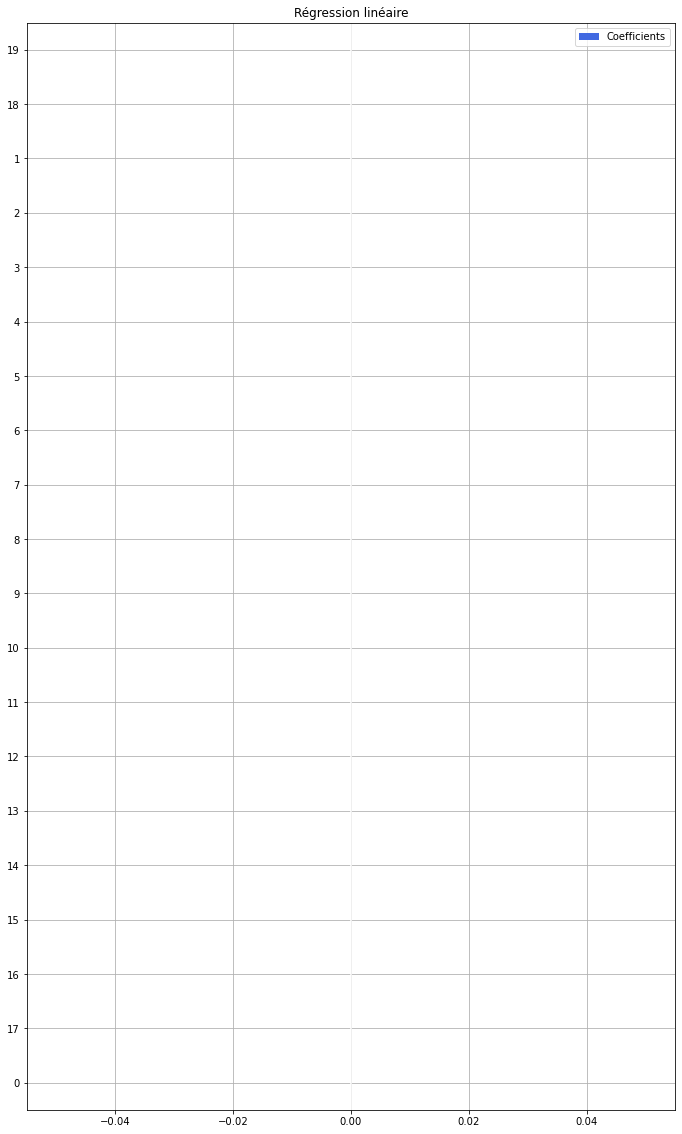

In [278]:
lasso = Lasso(fit_intercept = False, alpha = 0.1)
model_lasso =  lasso.fit(X_train, Y_train)
coef_lasso = model_lasso.coef_

coefs = pd.DataFrame(coef_lasso, columns=['Coefficients'], index = X_train.columns)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Régression linéaire')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

#On rend les coefficients normalisés pour que le poid soit égal à 1
coef_lasso_normalized = coef_lasso * abs(1/sum(coef_lasso))
print(coef_lasso_normalized)

Création fonction qui génère le tableau des rendements en ayant la possibilité de changer les paramètres

C'est raté

In [332]:
def generation_tableau_rdts(nb_actifs, nb_dates, list_esp_rdts, list_vols) :     
    idx = pd.Index(np.arange(nb_actifs))
    idx_date = pd.Index(np.arange(nb_dates))
    mu = np.zeros(nb_actifs)
    nb = len(list_esp_rdts)
    vol = np.zeros(nb_actifs)

    for i in range(nb):
        valeur_commune_mu = list_esp_rdts[i]
        debut_bloc = i * (nb_actifs // nb)
        fin_bloc = (i + 1) * (nb_actifs // nb)
        mu[debut_bloc:fin_bloc] = valeur_commune_mu
    print(mu)
    
    for i in range(nb):
        valeur_commune_vol = list_vols[i]
        debut_bloc = i * (nb_actifs // nb)
        fin_bloc = (i + 1) * (nb_actifs // nb)
        vol[debut_bloc:fin_bloc] = valeur_commune_vol
    print(vol)

    correl = 0.7

    #Matrice var-covar théorique selon la vraie loi des rendements
    covar = np.diag(vol) @ pd.DataFrame(correl * np.ones((nb_actifs,nb_actifs)) + (1-correl) * np.eye(nb_actifs),index=idx,columns=idx) @ np.diag(vol)

    #On simuler un tirage de rendements suivant une loi normale d'espérence Mu et de Var la matrice Covar
    A = np.linalg.cholesky(covar)
    rdts_observes = mu/256 + pd.DataFrame(np.random.randn(nb_dates,nb_actifs)) @ A.T / 16
    
    return rdts_observes

In [333]:
generation_tableau_rdts(30, 256, [0.05, 0.03, 0.1], [0.2, 0.15, 0.3])

[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1 ]
[0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.15 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3
 0.3  0.3 ]


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.002104,-0.001420,-0.004972,-0.007895,-0.007400,0.002997,-0.007367,-0.006750,-0.003834,-0.010522,...,-0.019720,0.003773,-0.016277,-0.023246,-0.021919,-0.011821,0.000046,-0.014158,0.001079,-0.005313
1,0.019915,-0.002822,0.009949,0.003931,0.010578,0.016890,0.009856,0.002864,0.008627,-0.006432,...,0.012706,0.008558,0.021481,0.002231,-0.007955,-0.006174,0.001111,-0.002019,0.017651,-0.014411
2,-0.008277,0.005284,0.007753,-0.003826,-0.001792,0.015330,0.014351,0.000914,0.001679,0.012213,...,0.006300,0.015666,0.008661,0.003337,-0.001182,0.000259,-0.009173,0.004593,0.011729,0.017021
3,0.012755,0.000547,0.009017,-0.009547,0.004589,0.003355,0.007627,0.011254,-0.008233,0.013534,...,-0.003407,0.006689,0.014649,0.002346,0.006361,0.011831,0.001453,0.006344,0.017117,0.014494
4,-0.004795,-0.000507,-0.004706,0.001267,0.001088,0.000134,0.000763,-0.004820,-0.018886,0.002961,...,-0.014578,-0.005326,-0.010282,-0.016879,-0.022817,-0.022360,0.000415,-0.015333,-0.002956,-0.010750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-0.009533,-0.006107,0.004971,-0.005341,-0.002577,0.007784,0.006766,-0.012403,0.000378,0.007345,...,-0.000128,-0.014724,-0.001971,-0.021380,-0.008737,-0.003578,-0.013721,-0.003771,0.010968,-0.015954
252,0.007524,-0.002972,0.001177,0.008149,-0.000055,0.008588,0.011365,0.002304,0.000124,0.004712,...,0.002010,0.007031,0.014276,0.032319,0.003057,0.020148,-0.003934,0.007090,-0.000682,0.008425
253,0.000392,-0.005973,0.001471,0.011056,0.006322,0.006116,0.003705,0.006554,0.005710,-0.002542,...,-0.008949,-0.007136,-0.003111,0.007165,-0.010385,-0.022290,0.005715,0.002149,0.000289,-0.003992
254,-0.005173,-0.004029,-0.000991,-0.001860,-0.011289,0.001539,-0.000152,-0.007518,0.002472,-0.005805,...,-0.014408,0.023348,0.010846,-0.009224,0.013750,0.010403,-0.010072,0.002815,0.017724,-0.010357
